In [1]:
import scanpy as sc
import pandas as pd
import seaborn as sns

In [2]:
sc.settings.verbosity = 1             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80, frameon=False, figsize=(3, 3), facecolor='white')

The `sinfo` package has changed name and is now called `session_info` to become more discoverable and self-explanatory. The `sinfo` PyPI package will be kept around to avoid breaking old installs and you can downgrade to 0.3.2 if you want to use it without seeing this message. For the latest features and bug fixes, please install `session_info` instead. The usage and defaults also changed slightly, so please review the latest README at https://gitlab.com/joelostblom/session_info.
-----
anndata     0.7.8
scanpy      1.8.2
sinfo       0.3.4
-----
PIL                 8.2.0
anyio               NA
appnope             0.1.2
attr                20.3.0
babel               2.9.0
backcall            0.2.0
bottleneck          1.3.2
brotli              NA
cairo               1.20.1
certifi             2020.12.05
cffi                1.14.5
chardet             4.0.0
cloudpickle         1.6.0
colorama            0.4.4
cycler              0.10.0
cython_runtime      NA
cytoolz             0.11.0
dask  

In [3]:
adata_ref = sc.datasets.pbmc3k_processed()  # this is an earlier version of the dataset from the pbmc3k tutorial
adata = sc.datasets.pbmc68k_reduced()

  0%|          | 0.00/23.5M [00:00<?, ?B/s]

In [4]:
var_names = adata_ref.var_names.intersection(adata.var_names)
adata_ref = adata_ref[:, var_names]
adata = adata[:, var_names]

In [5]:
sc.pp.pca(adata_ref)
sc.pp.neighbors(adata_ref)
sc.tl.umap(adata_ref)

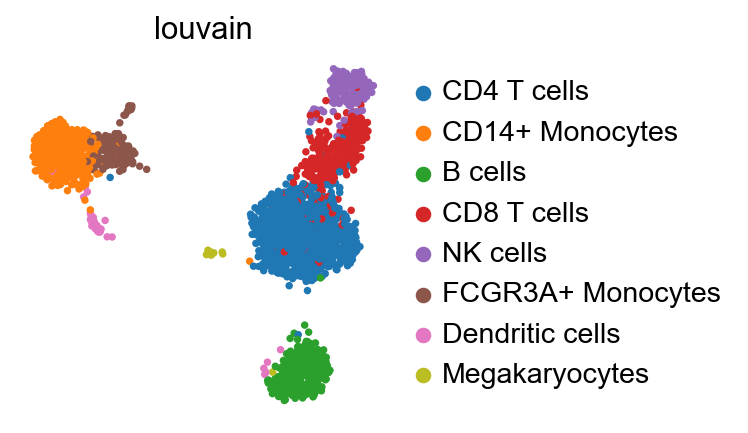

In [6]:
sc.pl.umap(adata_ref, color='louvain')

In [7]:
sc.tl.ingest(adata, adata_ref, obs='louvain')

In [8]:
adata.uns['louvain_colors'] = adata_ref.uns['louvain_colors']  # fix colors

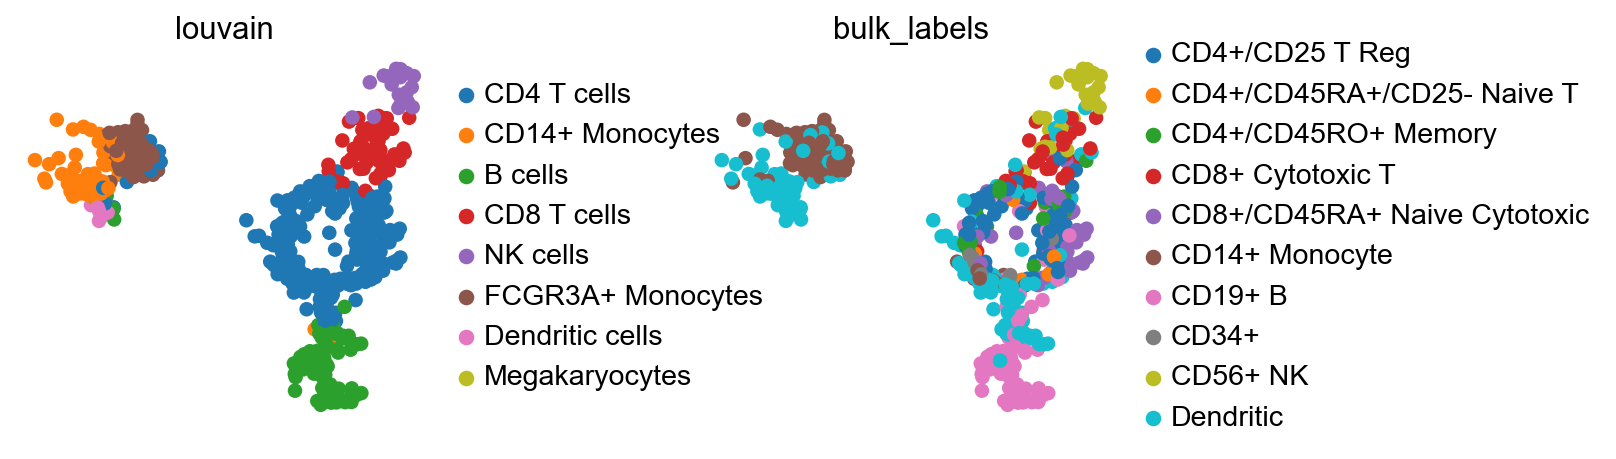

In [9]:
sc.pl.umap(adata, color=['louvain', 'bulk_labels'], wspace=0.5)

In [10]:
adata_concat = adata_ref.concatenate(adata, batch_categories=['ref', 'new'])

In [11]:
adata_concat.obs.louvain = adata_concat.obs.louvain.astype('category')
adata_concat.obs.louvain.cat.reorder_categories(adata_ref.obs.louvain.cat.categories, inplace=True)  # fix category ordering
adata_concat.uns['louvain_colors'] = adata_ref.uns['louvain_colors']  # fix category colors

... storing 'bulk_labels' as categorical
... storing 'phase' as categorical


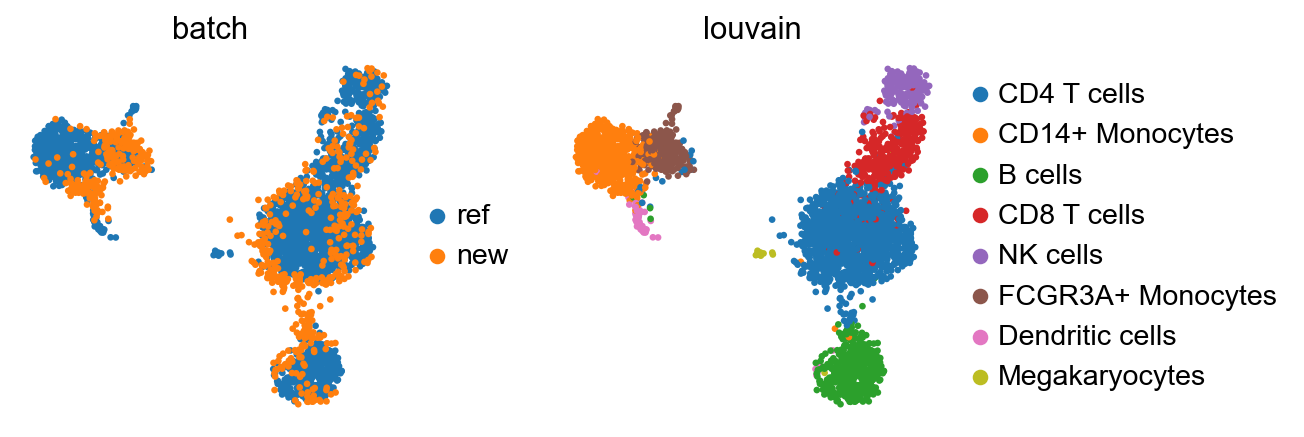

In [12]:
sc.pl.umap(adata_concat, color=['batch', 'louvain'])

In [13]:
sc.tl.pca(adata_concat)

In [14]:
%%time
sc.external.pp.bbknn(adata_concat, batch_key='batch')  # running bbknn 1.3.6

ImportError: Please install bbknn: `pip install bbknn`.

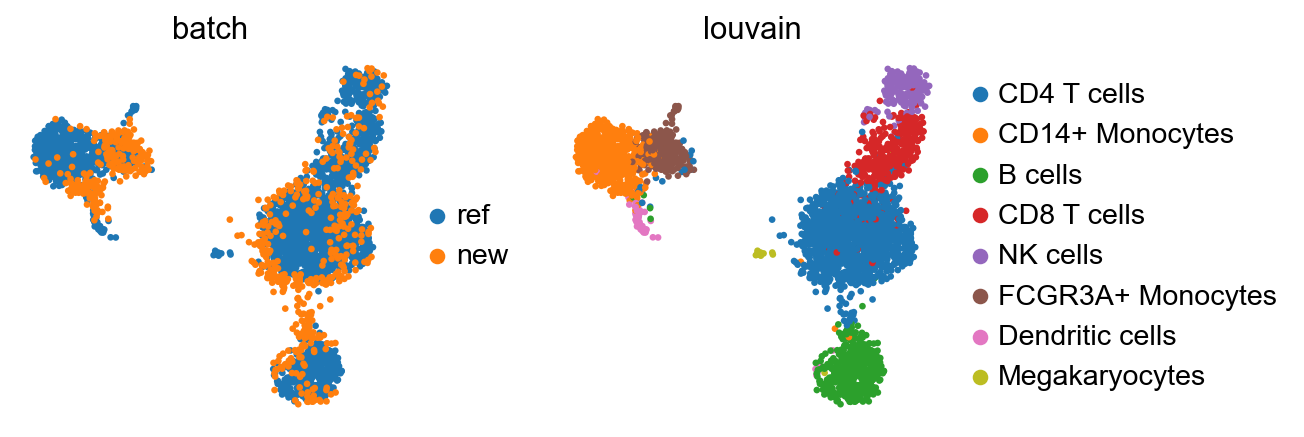

In [15]:
sc.pl.umap(adata_concat, color=['batch', 'louvain'])

In [16]:
# note that this collection of batches is already intersected on the genes
adata_all = sc.read('data/pancreas.h5ad', backup_url='https://www.dropbox.com/s/qj1jlm9w10wmt0u/pancreas.h5ad?dl=1')

  0%|          | 0.00/176M [00:00<?, ?B/s]

/Users/sadeq/opt/anaconda3/lib/python3.8/site-packages/anndata/compat/__init__.py:180: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(
/Users/sadeq/opt/anaconda3/lib/python3.8/site-packages/anndata/compat/__init__.py:180: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  warn(


In [17]:
adata_all.shape

(14693, 2448)

In [18]:
counts = adata_all.obs.celltype.value_counts()
counts

alpha                     4214
beta                      3354
ductal                    1804
acinar                    1368
not applicable            1154
delta                      917
gamma                      571
endothelial                289
activated_stellate         284
dropped                    178
quiescent_stellate         173
mesenchymal                 80
macrophage                  55
PSC                         54
unclassified endocrine      41
co-expression               39
mast                        32
epsilon                     28
mesenchyme                  27
schwann                     13
t_cell                       7
MHC class II                 5
unclear                      4
unclassified                 2
Name: celltype, dtype: int64

In [19]:
minority_classes = counts.index[-5:].tolist()        # get the minority classes
adata_all = adata_all[                               # actually subset
    ~adata_all.obs.celltype.isin(minority_classes)]
adata_all.obs.celltype.cat.reorder_categories(       # reorder according to abundance
    counts.index[:-5].tolist(), inplace=True)

In [20]:
sc.pp.pca(adata_all)
sc.pp.neighbors(adata_all)
sc.tl.umap(adata_all)

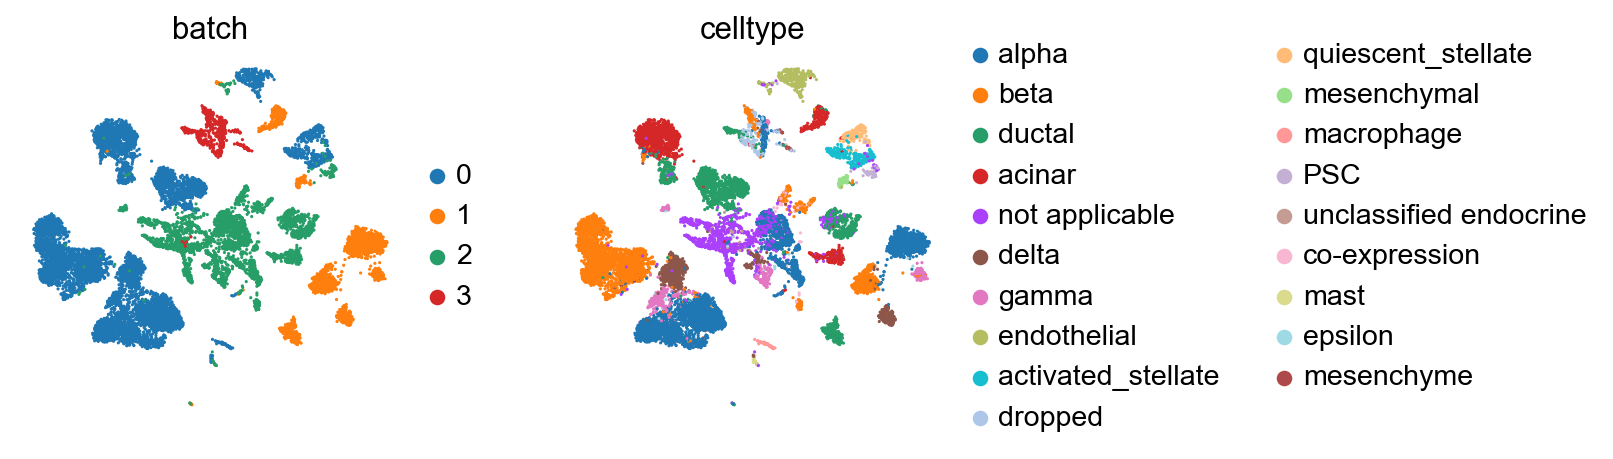

In [21]:
sc.pl.umap(adata_all, color=['batch', 'celltype'], palette=sc.pl.palettes.vega_20_scanpy)


In [22]:
%%time
sc.external.pp.bbknn(adata_all, batch_key='batch')

ImportError: Please install bbknn: `pip install bbknn`.

In [23]:
sc.tl.umap(adata_all)

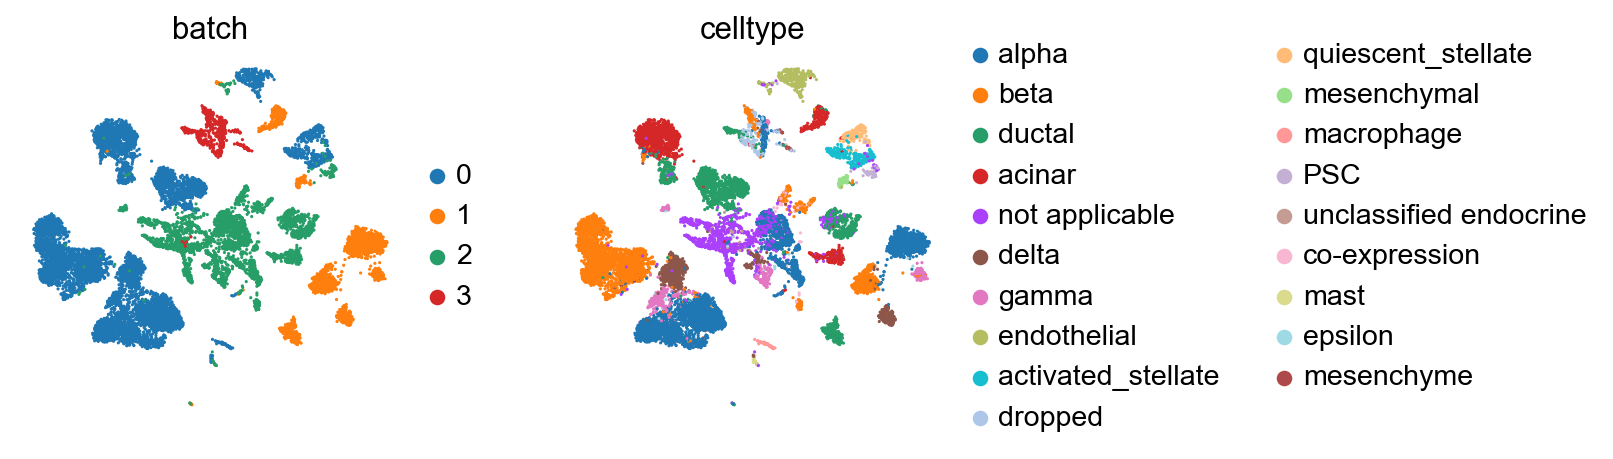

In [24]:
sc.pl.umap(adata_all, color=['batch', 'celltype'])


In [25]:
adata_ref = adata_all[adata_all.obs.batch == '0']


In [26]:
sc.pp.pca(adata_ref)
sc.pp.neighbors(adata_ref)
sc.tl.umap(adata_ref)

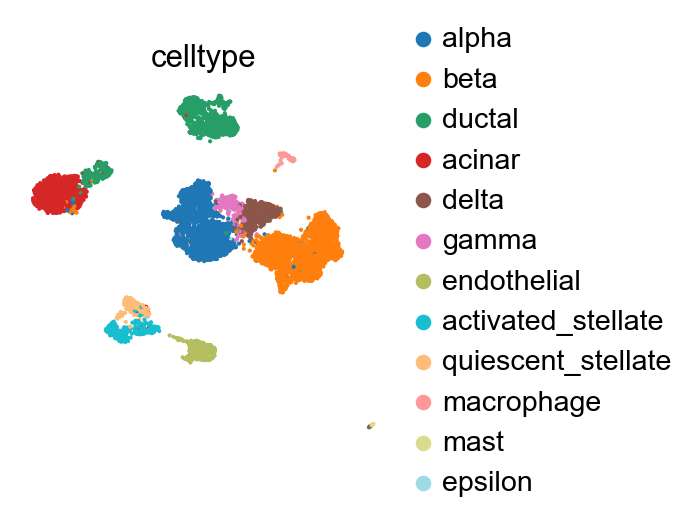

In [27]:
sc.pl.umap(adata_ref, color='celltype')


In [28]:
adatas = [adata_all[adata_all.obs.batch == i].copy() for i in ['1', '2', '3']]


In [29]:
sc.settings.verbosity = 2  # a bit more logging
for iadata, adata in enumerate(adatas):
    print(f'... integrating batch {iadata+1}')
    adata.obs['celltype_orig'] = adata.obs.celltype  # save the original cell type
    sc.tl.ingest(adata, adata_ref, obs='celltype')

... integrating batch 1
running ingest
    finished (0:00:04)
... integrating batch 2
running ingest
    finished (0:00:05)
... integrating batch 3
running ingest
    finished (0:00:02)


In [30]:
adata_concat = adata_ref.concatenate(adatas)


In [31]:
adata_concat.obs.celltype = adata_concat.obs.celltype.astype('category')
adata_concat.obs.celltype.cat.reorder_categories(adata_ref.obs.celltype.cat.categories, inplace=True)  # fix category ordering
adata_concat.uns['celltype_colors'] = adata_ref.uns['celltype_colors']  # fix category coloring

... storing 'sample' as categorical
... storing 'louvain' as categorical
... storing 'celltype_orig' as categorical


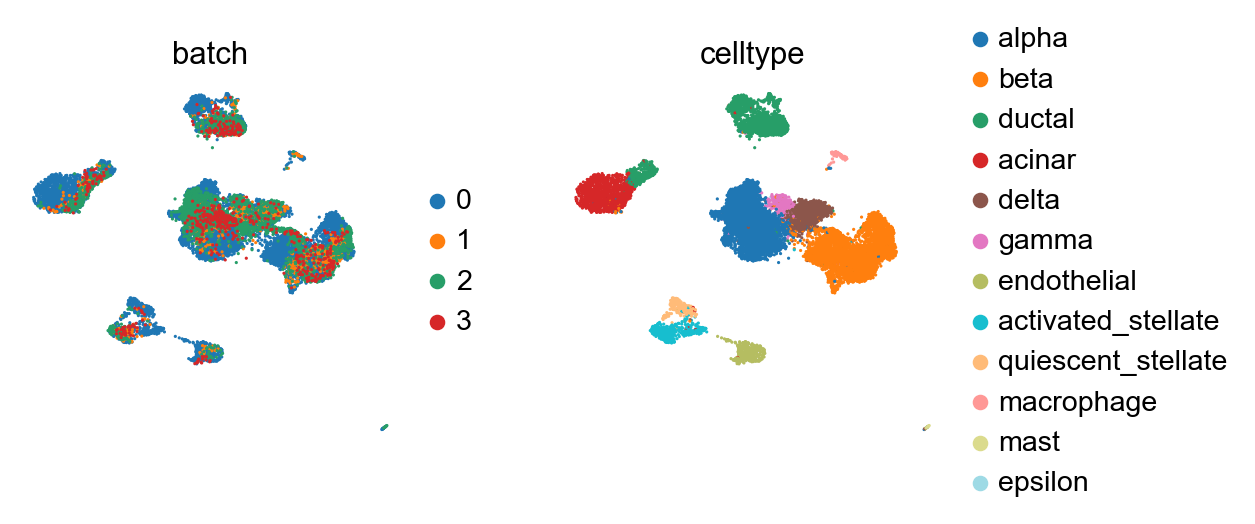

In [32]:
sc.pl.umap(adata_concat, color=['batch', 'celltype'])


In [33]:
adata_query = adata_concat[adata_concat.obs.batch.isin(['1', '2', '3'])]


Trying to set attribute `._uns` of view, copying.


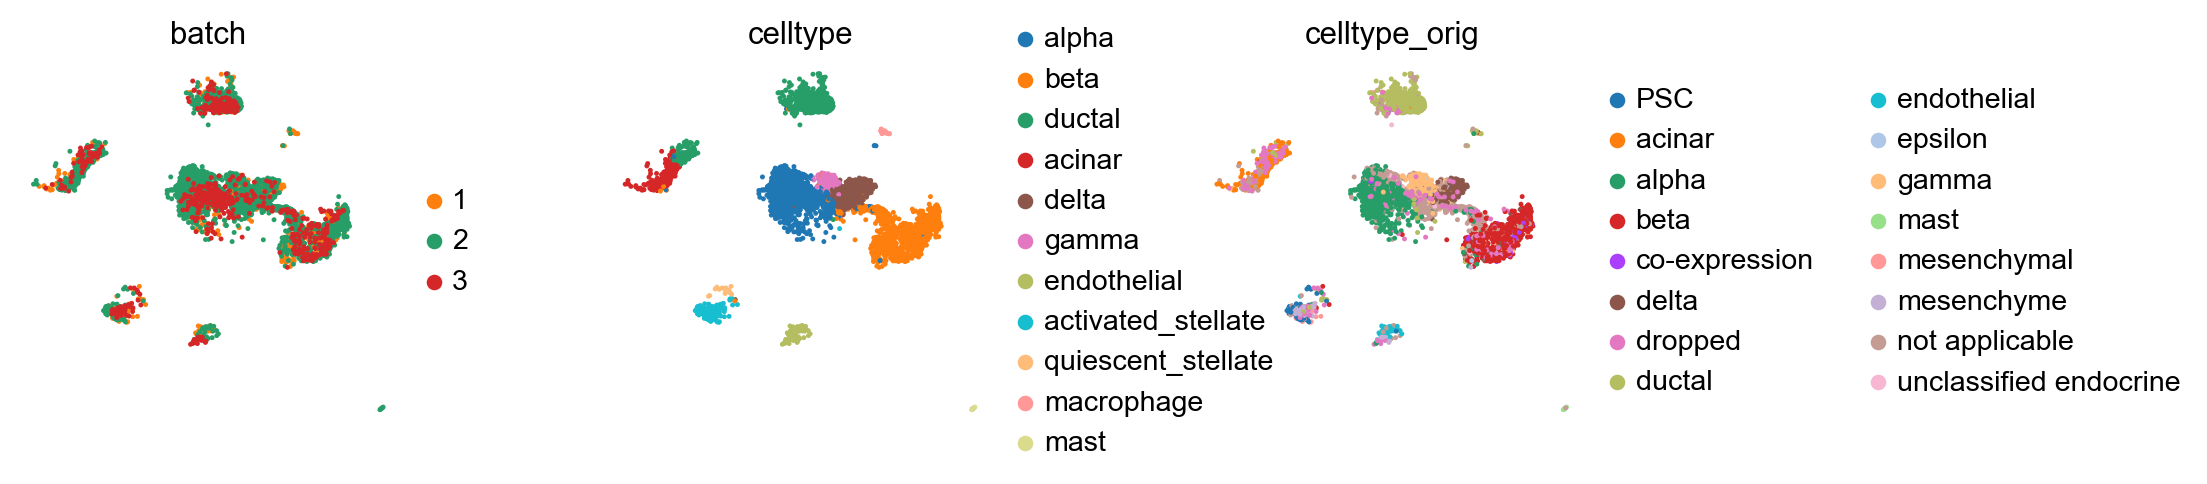

In [34]:
sc.pl.umap(
    adata_query, color=['batch', 'celltype', 'celltype_orig'], wspace=0.4)

In [35]:
obs_query = adata_query.obs
conserved_categories = obs_query.celltype.cat.categories.intersection(obs_query.celltype_orig.cat.categories)  # intersected categories
obs_query_conserved = obs_query.loc[obs_query.celltype.isin(conserved_categories) & obs_query.celltype_orig.isin(conserved_categories)]  # intersect categories
obs_query_conserved.celltype.cat.remove_unused_categories(inplace=True)  # remove unused categoriyes
obs_query_conserved.celltype_orig.cat.remove_unused_categories(inplace=True)  # remove unused categoriyes
obs_query_conserved.celltype_orig.cat.reorder_categories(obs_query_conserved.celltype.cat.categories, inplace=True)  # fix category ordering

/Users/sadeq/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [36]:
pd.crosstab(obs_query_conserved.celltype, obs_query_conserved.celltype_orig)

celltype_orig,alpha,beta,ductal,acinar,delta,gamma,endothelial,mast
celltype,,,,,,,,
alpha,1812,3,7,0,1,20,0,3
beta,54,805,4,1,11,32,0,0
ductal,7,5,691,243,0,0,0,0
acinar,2,3,3,165,0,3,0,0
delta,6,3,1,0,304,70,0,0
gamma,2,5,0,0,0,191,0,0
endothelial,2,0,0,0,0,0,36,0
mast,0,0,1,0,0,0,0,4


In [37]:
pd.crosstab(adata_query.obs.celltype, adata_query.obs.celltype_orig)


celltype_orig,PSC,acinar,alpha,beta,co-expression,delta,dropped,ductal,endothelial,epsilon,gamma,mast,mesenchymal,mesenchyme,not applicable,unclassified endocrine
celltype,,,,,,,,,,,,,,,,
alpha,0,0,1812,3,3,1,34,7,0,3,20,3,0,0,306,10
beta,1,1,54,805,35,11,41,4,0,0,32,0,0,1,521,24
ductal,0,243,7,5,0,0,39,691,0,0,0,0,1,0,101,1
acinar,0,165,2,3,0,0,27,3,0,0,3,0,0,0,91,0
delta,0,0,6,3,1,304,13,1,0,6,70,0,0,0,94,6
gamma,0,0,2,5,0,0,1,0,0,1,191,0,0,0,14,0
endothelial,1,0,2,0,0,0,7,0,36,0,0,0,0,6,7,0
activated_stellate,48,1,1,3,0,0,11,7,0,0,0,0,79,20,17,0
quiescent_stellate,4,0,1,1,0,0,5,1,1,0,0,0,0,0,1,0


In [38]:
sc.tl.embedding_density(adata_concat, groupby='batch')


computing density on 'umap'


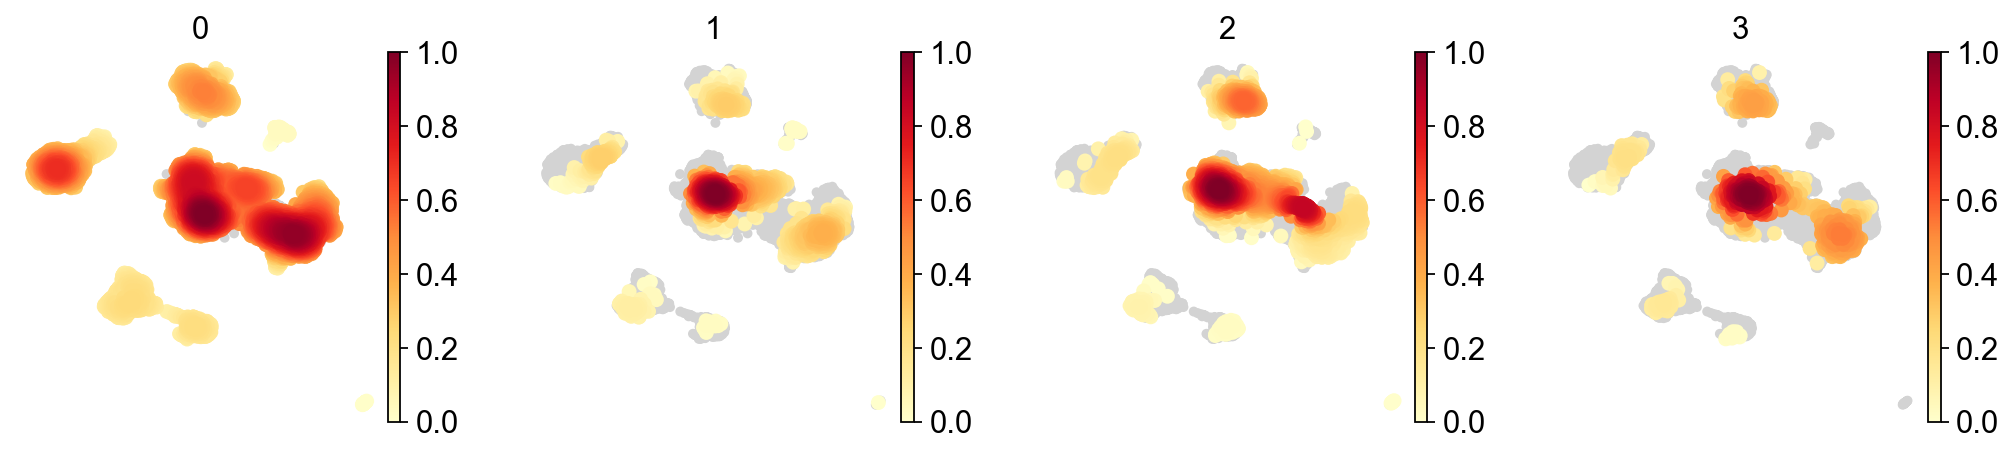

In [39]:
sc.pl.embedding_density(adata_concat, groupby='batch')


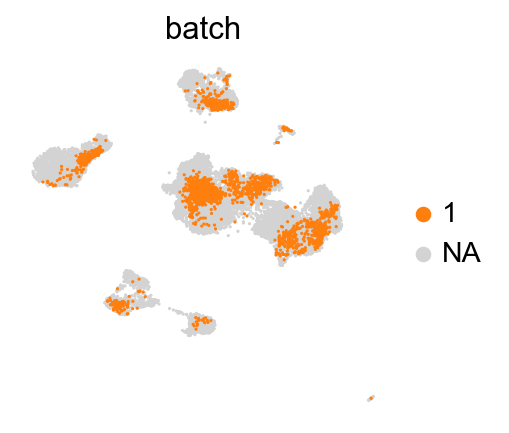

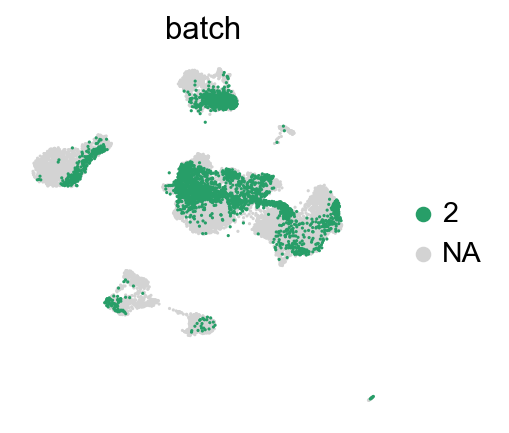

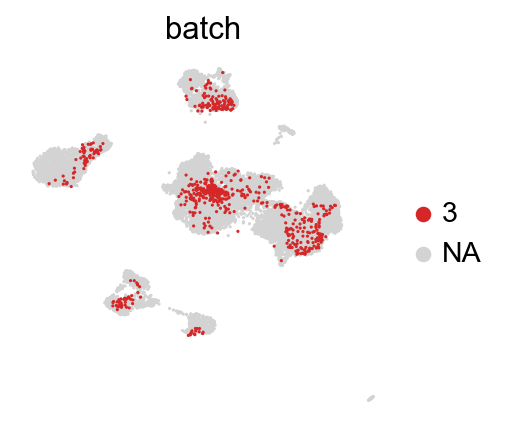

In [40]:
for batch in ['1', '2', '3']:
    sc.pl.umap(adata_concat, color='batch', groups=[batch])